In [1]:
%matplotlib inline

import datetime

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import utide

print(utide.__version__)

/Users/haonanzhang/Library/Python/3.9/lib/python/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/Users/haonanzhang/Library/Python/3.9/lib/python/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


0.3.0


In [1]:
# prompt: !pip install utide

import os

# Check if UTide directory exists, if not, clone it
# if not os.path.exists('UTide'):
#     !git clone https://github.com/wesleybowman/UTide.git

# Add UTide to the Python path
import sys
sys.path.insert(0, 'UTide')

import utide

utide.__version__

/Users/haonanzhang/Library/Python/3.9/lib/python/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/Users/haonanzhang/Library/Python/3.9/lib/python/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


'0.3.0'

In [2]:
pip install utide

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
with open("dataProcessed/MIL2019.csv") as f:
    lines = f.readlines()

print("".join(lines[:5]))

time,anomaly
2019-01-01 00:00:00,1.231M
2019-01-01 00:15:00,1.104M
2019-01-01 00:30:00,1.003M
2019-01-01 00:45:00,0.909M



In [22]:
import pandas as pd

obs = pd.read_csv(
    'dataProcessed/MIL20231.csv',
    usecols=['time', 'Water_Level_LAT'],
    na_values='9.990'
)

obs['time'] = pd.to_datetime(obs['time'])
obs = obs.set_index('time')
print(obs.head(5))




                     Water_Level_LAT
time                                
2023-01-01 00:00:00            1.367
2023-01-01 00:15:00            1.289
2023-01-01 00:30:00            1.225
2023-01-01 00:45:00            1.187
2023-01-01 01:00:00            1.168


In [23]:
import pandas as pd

print(obs['Water_Level_LAT'].describe())


count    35040.000000
mean         2.122189
std          1.016141
min          0.001000
25%          1.396000
50%          2.171000
75%          2.850000
max         99.000000
Name: Water_Level_LAT, dtype: float64


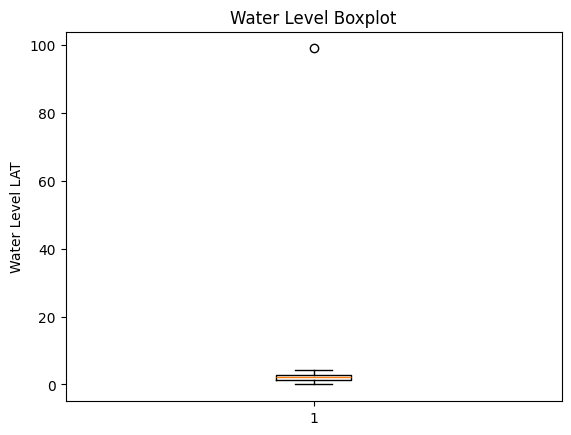

In [24]:
import matplotlib.pyplot as plt

plt.boxplot(obs['Water_Level_LAT'].dropna())
plt.title('Water Level Boxplot')
plt.ylabel('Water Level LAT')
plt.show()


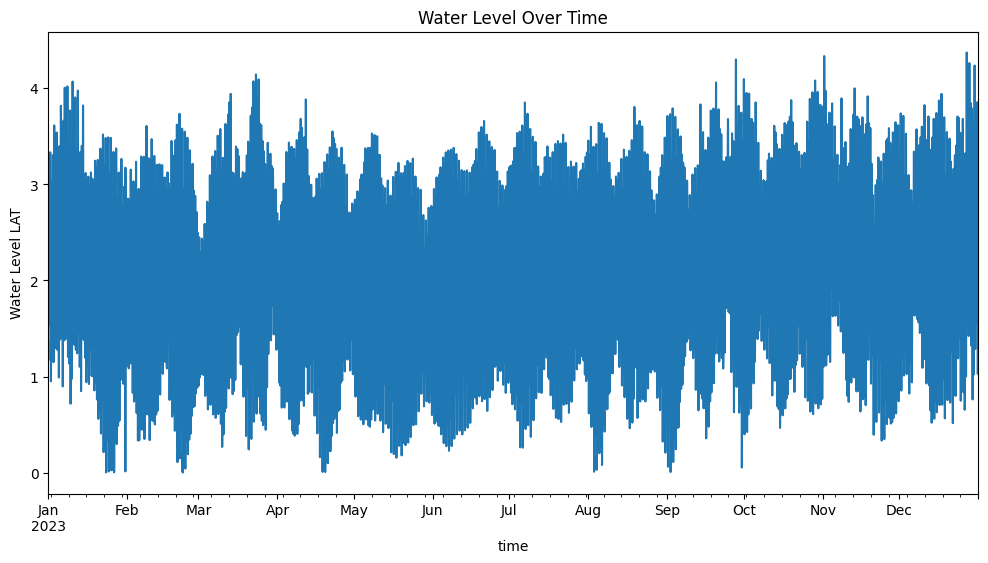

In [37]:

obs['Water_Level_LAT'].plot(figsize=(12, 6))
plt.title('Water Level Over Time')
plt.ylabel('Water Level LAT')
plt.show()


In [35]:
import pandas as pd
import numpy as np

threshold = 20

obs.loc[obs['Water_Level_LAT'] > threshold, 'Water_Level_LAT'] = np.nan

num_replaced = obs['Water_Level_LAT'].isna().sum()
print(f'totally {num_replaced} have been replaced by NaN。')

obs['Water_Level_LAT'] = obs['Water_Level_LAT'].interpolate(method='time')

remaining_nans = obs['Water_Level_LAT'].isna().sum()
print(f'still {remaining_nans} haven been replaced。')

obs['Water_Level_LAT'] = obs['Water_Level_LAT'].fillna(method='ffill').fillna(method='bfill')


totally 1 have been replaced by NaN。
still 0 haven been replaced。


/var/folders/mm/h47z2s357dq24sj3f9lbwsqc0000gn/T/ipykernel_10544/4160223520.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  obs['Water_Level_LAT'] = obs['Water_Level_LAT'].fillna(method='ffill').fillna(method='bfill')


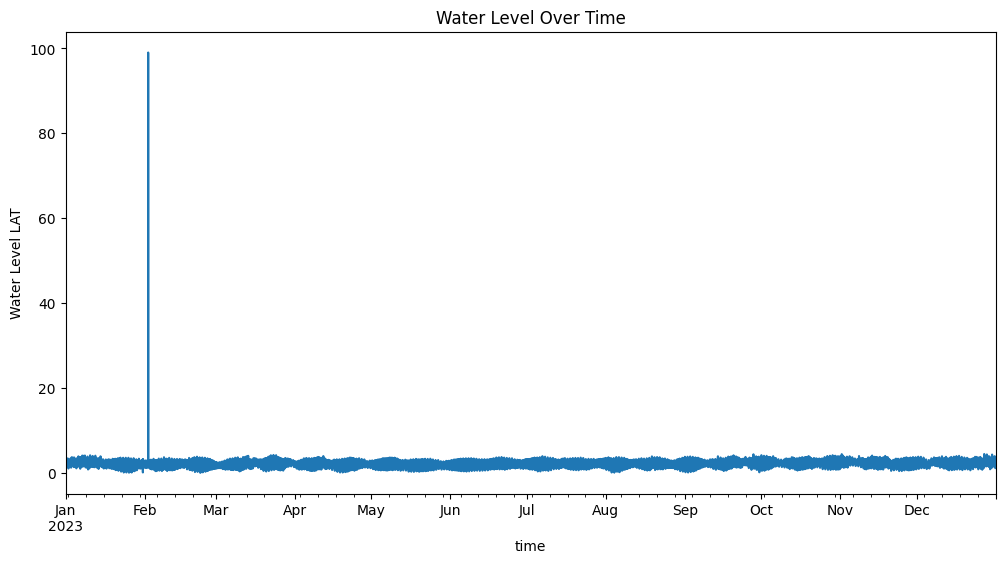

In [36]:
obs['Water_Level_LAT1'].plot(figsize=(12, 6))
plt.title('Water Level Over Time')
plt.ylabel('Water Level LAT')
plt.show()


In [14]:
obs["Water_Level_LAT1"] = obs["Water_Level_LAT"] - obs["Water_Level_LAT"].mean()
obs["Water_Level_LAT1"] = obs["Water_Level_LAT1"].interpolate()

In [38]:
obs["Water_Level_LAT1"] = obs["Water_Level_LAT"]
obs["Water_Level_LAT1"] = obs["Water_Level_LAT1"].interpolate()

In [39]:
coef = utide.solve(
    obs.index,
    obs["Water_Level_LAT1"],
    lat=-25,
    method="ols",
    conf_int="MC",
    verbose=False,
)

In [40]:
print(coef.keys())

dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])


In [41]:
tide = utide.reconstruct(obs.index, coef, verbose=False)

In [42]:
print(tide.keys())

dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])


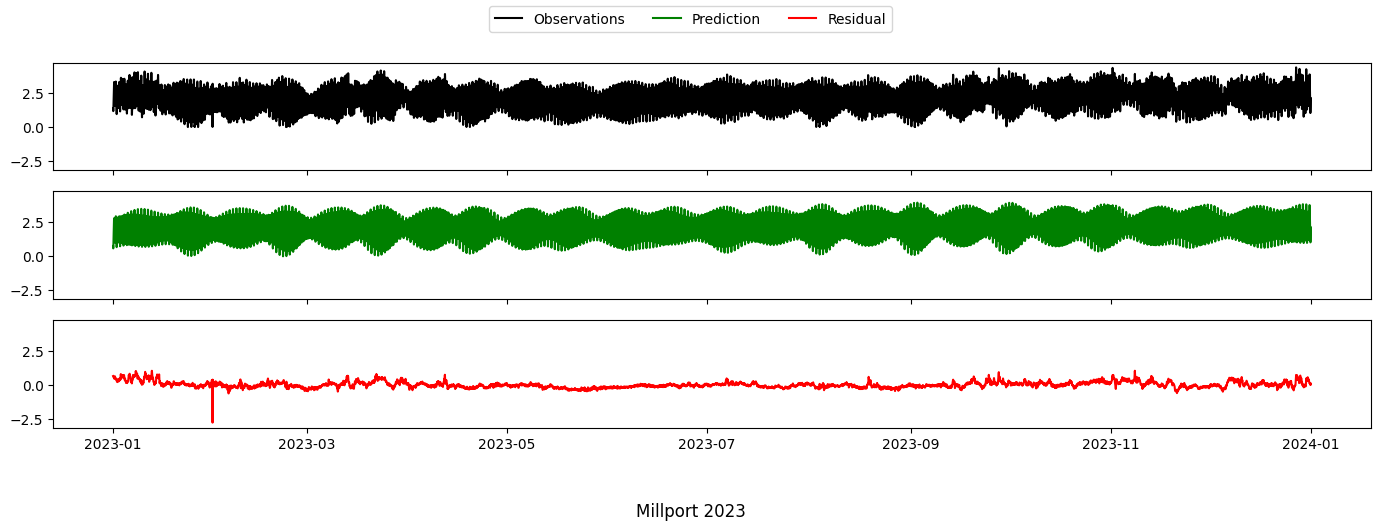

In [60]:
t = obs.index.to_pydatetime()

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 5), nrows=3, sharey=True, sharex=True)

ax0.plot(t, obs.Water_Level_LAT1, label="Observations", color="black")
ax1.plot(t, tide.h, label="Prediction", color="green")
ax2.plot(t, obs.Water_Level_LAT1 - tide.h, label="Residual", color="red")

fig.legend(ncol=3, loc="upper center")

# 设置主标题并调整位置到最下面
fig.suptitle('Millport 2023', y = 0.001)  # y 值调整标题位置
plt.subplots_adjust(bottom=0.15)  # 增加底部空间以容纳标题

plt.show()

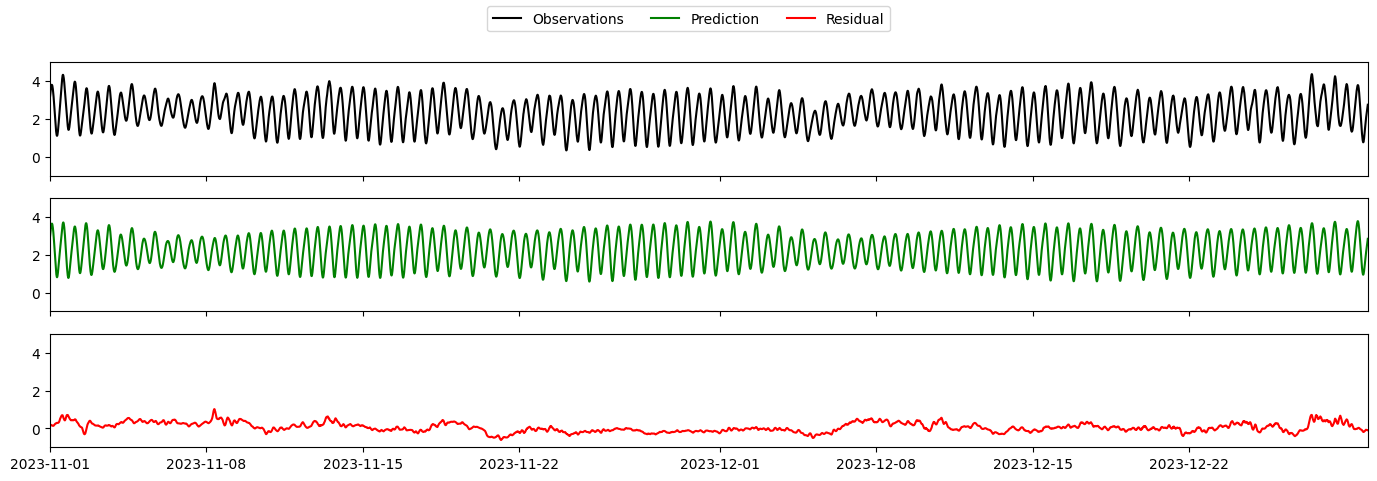

In [51]:
start_time = "2023-11-01"
end_time = "2023-12-30"

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 5), nrows=3, sharey=True, sharex=True)

ax0.plot(t, obs.Water_Level_LAT1, label="Observations", color="black")
ax1.plot(t, tide.h, label="Prediction", color="green")
ax2.plot(t, obs.Water_Level_LAT1 - tide.h, label="Residual", color="red")

ax0.set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
ax0.set_ylim(-1,5)
fig.legend(ncol=3, loc="upper center")
plt.show()

In [66]:
print(list(tide.h[:10]))

[-0.10271660904317156, -0.22978871241427068, -0.3538621032305652, -0.4725447931909092, -0.583724692597882, -0.6856638314966135, -0.7770209099062193, -0.8568040818217793, -0.9242732374758351, -0.9788233587589107]


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

anomaly_series = obs['Water_Level_LAT1']
tide_series = pd.Series(tide.h, index=obs.index)

result_df = pd.DataFrame({
    'time': obs.index,
    'anomaly': anomaly_series,
    'tide_h': tide_series
})

result_df.to_csv('dataProcessed/BOU2019_HA.csv', index=False)
